In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polpo.preprocessing.dict as ppdict
import polpo.preprocessing.pd as ppd
from polpo.model_eval import (
    MultiEvaluator,
    OlsPValues,
    R2Score,
    ReconstructionError,
    VertexReconstructionError,
    collect_eval_results,
)
from polpo.preprocessing import (
    IndexMap,
    Map,
    NestingSwapper,
    PartiallyInitializedStep,
)
from polpo.preprocessing.load.pregnancy import (
    NeuroMaternalMeshLoader,
    NeuroMaternalTabularDataLoader,
)
from polpo.preprocessing.mesh.conversion import PvFromData, ToVertices
from polpo.preprocessing.mesh.io import FreeSurferReader
from polpo.preprocessing.mesh.registration import PvAlign
from polpo.sklearn.adapter import AdapterPipeline, EvaluatedModel
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
DEBUG = False

EDS.

In [3]:
pipe = NeuroMaternalTabularDataLoader(
    keep_mothers=True,
    keep_control=False,
)

tab_data = pipe()

In [4]:
eds_pipe = (
    ppd.DfFilter(lambda df: df["ses"] == 1)
    + ppd.IndexSetter("participant_id", drop=True)
    + ppd.ColumnsSelector("EDS.Total")
    + ppd.SeriesToDict()
)

eds_dict = eds_pipe(tab_data)

eds_dict

{'049ab1a591': 2.0,
 '082dc070c1': 12.0,
 '085a9ee2fc': 5.0,
 '0872b8db24': 4.0,
 '0a9b5eb6f1': 10.0,
 '0b6820582a': 5.0,
 '11a123772c': 12.0,
 '15255749dc': 3.0,
 '15901c4398': 5.0,
 '17641fc443': 10.0,
 '17ca82ae03': 3.0,
 '1db8e32656': 1.0,
 '22cdbe0c1b': 6.0,
 '254daf33ca': 0.0,
 '2edf82ffc5': 8.0,
 '306d3a97b3': 13.0,
 '31879f2221': 2.0,
 '343a5d44e7': 12.0,
 '39dd102cbf': 7.0,
 '3b4d062226': 6.0,
 '3c4a4a2b19': 11.0,
 '3cb6244806': 8.0,
 '3f68c4406d': 7.0,
 '471db43041': 15.0,
 '4732ae8cde': 3.0,
 '47fb269f0c': 1.0,
 '4abde43b71': 11.0,
 '4c1ea69777': 2.0,
 '4cede517b5': 2.0,
 '4cf50fd8bc': 8.0,
 '5356354624': 3.0,
 '57622fa0f9': 7.0,
 '57747cb2eb': 0.0,
 '584e7fbdba': 11.0,
 '593ac50159': 0.0,
 '5aa6c7faa1': 1.0,
 '5b139f503d': 3.0,
 '5c1ae9ac67': 1.0,
 '5e867e35e6': 20.0,
 '6021ebb443': 17.0,
 '63db63081a': 2.0,
 '66ed43826b': 5.0,
 '6733e7702c': 8.0,
 '67eb38f7e9': 2.0,
 '68f8586911': 1.0,
 '690eec56c3': 5.0,
 '6b9079271c': 0.0,
 '6dc2a2528b': 7.0,
 '6e5a9fb778': 2.0,
 '6e902e

Meshes and vector fields.

In [5]:
as_dict = False
file_finder = NeuroMaternalMeshLoader(as_dict=as_dict)

Map_ = ppdict.DictMap if as_dict else Map


mesh_reader = ppdict.DictMap(Map_(FreeSurferReader() + PvFromData()))

prep_pipe = PartiallyInitializedStep(
    Step=lambda **kwargs: ppdict.DictMap(Map_(PvAlign(**kwargs))),
    # NB: aligns against first subject, t_0
    _target=lambda meshes: meshes[list(meshes.keys())[0]][0],
    max_iterations=500,
)


if DEBUG:
    # because alignment is a bit slow
    pipe = file_finder + mesh_reader
else:
    pipe = file_finder + mesh_reader + prep_pipe


meshes_dict = pipe()

len(meshes_dict)

151

In [6]:
meshes2flat_vfields = ppdict.DictMap(
    step=Map(ToVertices()) + (lambda verts: (verts[1] - verts[0]).flatten())
)

flat_vfields_dict = meshes2flat_vfields(meshes_dict)

len(flat_vfields_dict)

151

In [7]:
model = EvaluatedModel(
    AdapterPipeline(
        [
            (
                "prep",
                EvaluatedModel(
                    PLSRegression(n_components=1),
                    MultiEvaluator(
                        [
                            ReconstructionError(),
                            VertexReconstructionError(prefix="vertex"),
                        ]
                    ),
                ),
            ),
            (
                "regr",
                EvaluatedModel(
                    LinearRegression(),
                    MultiEvaluator([OlsPValues(), R2Score()]),
                ),
            ),
        ]
    ),
    R2Score(),
)

model

,model,AdapterPipeli...gression()))])
,evaluator,<polpo.model_...x7bb67125af00>
,model,PLSRegression(n_components=1)
,evaluator,<polpo.model_...x7bb6706b4290>
,n_components,1
,scale,True
,max_iter,500
,tol,1e-06
,copy,True
,model,LinearRegression()
,evaluator,<polpo.model_...x7bb6706b5490>


In [8]:
dataset_pipe = (
    ppdict.DictMerger()
    + NestingSwapper()
    + IndexMap(index=0, step=lambda x: np.stack(x))
    + IndexMap(index=1, step=lambda x: np.stack(x)[:, None])
)


flat_vfields, eds = dataset_pipe((flat_vfields_dict, eds_dict))

flat_vfields.shape, eds.shape

((117, 7506), (117, 1))

In [9]:
X, y = flat_vfields, eds

model.fit(X, y)

,model,AdapterPipeli...gression()))])
,evaluator,<polpo.model_...x7bb67125af00>
,model,PLSRegression(n_components=1)
,evaluator,<polpo.model_...x7bb6706b4290>
,n_components,1
,scale,True
,max_iter,500
,tol,1e-06
,copy,True
,model,LinearRegression()
,evaluator,<polpo.model_...x7bb6706b5490>


In [10]:
eval_res = collect_eval_results(model, unnest=True, outer_key="full")

print(list(eval_res.keys()))

['full', 'full/prep', 'full/regr']


Eval results of full pipeline.

In [11]:
eval_res["full"]

{'r2': array([0.14761536])}

Eval results of inner regression (PLS component -> EDS).

In [12]:
eval_res["full/regr"]

{'mse': array([20.48637277]),
 'res_var': array([20.84265752]),
 'std_err': array([[0.02583535]]),
 't': array([[4.46269168]]),
 'pvals': array([[1.89812058e-05]]),
 'adj-pvals': array([[1.89812058e-05]]),
 'r2': array([0.14761536])}

Eval results of PLS reconstruction.

In [13]:
eval_res["full/prep"]

{'featurewise_rec_error': array([15.98668262, 18.99377637,  7.75389366, ..., 49.69924518,
        33.52541568, 13.12929494], shape=(7506,)),
 'rec_error_sum': np.float64(110830.37791783523),
 'rec_error_mse': np.float64(0.12620146380654476),
 'vertex-vertexwise_rec_error': array([ 42.73435265,  42.4259018 ,  44.43781958, ...,  94.40772419,
        101.50874104,  96.3539558 ], shape=(2502,)),
 'vertex-rec_error_sum': np.float64(110830.37791783517),
 'vertex-rec_error_mse': np.float64(0.3786043914196341)}

Visualization.

Text(0.5, 1.0, 'Linear Regression: Deformation Component vs. EPDS')

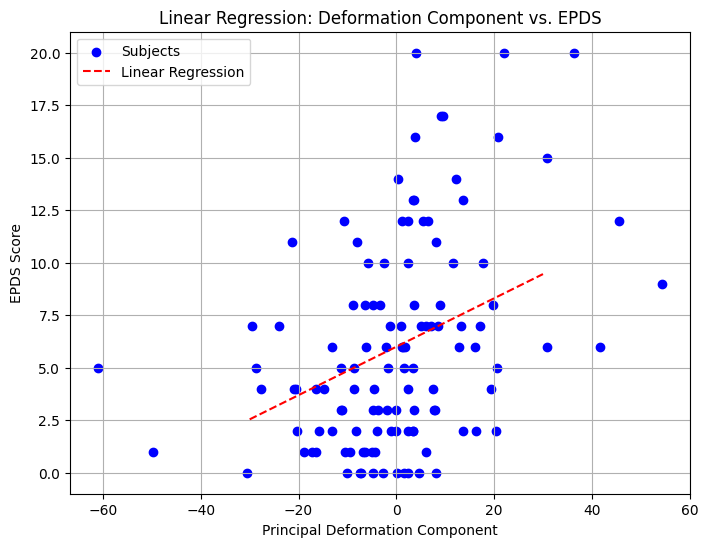

In [14]:
encoder = model.named_steps["prep"]
regressor = model.named_steps["regr"]

Z = encoder.transform(X)

z = np.linspace(-30.0, 30.0)[:, None]


plt.figure(figsize=(8, 6))
plt.scatter(Z, eds, color="blue", label="Subjects")
plt.plot(
    z,
    regressor.predict(z),
    color="red",
    linestyle="--",
    label="Linear Regression",
)
plt.legend()
plt.grid(True)
plt.xlabel("Principal Deformation Component")
plt.ylabel("EPDS Score")
plt.title("Linear Regression: Deformation Component vs. EPDS")